# Encontro 13: Medidas de Centralidade

Importando a biblioteca:

In [28]:
import sys
sys.path.append('..')

from random import choice
from itertools import permutations

import pandas as pd
import networkx as nx

import socnet as sn

from scipy import stats

import matplotlib.pyplot as plt

import math

Configurando a biblioteca:

In [3]:
sn.node_size = 10
sn.node_color = (255, 255, 255)

sn.edge_width = 1
sn.edge_color = (192, 192, 192)

sn.node_label_position = 'top center'

Carregando rede de casamentos entre famílias de Florença durante a Renascença.

J. F. Padgett e C. K. Ansell. *Robust action and the rise of the Medici, 1400–1434.* American Journal of
Sociology 98, págs. 1259-1319, 1993.

In [4]:
g = sn.load_graph('Renaissance.gml', has_pos=True)

sn.show_graph(g, nlab=True)

Função que registra, em cada nó, seus sucessores em geodésicas de $s$ a $t$.

In [5]:
def set_geodesic_successors(g, s, t):
    for n in g.nodes:
        g.nodes[n]['geodesic_successors'] = set()

    for p in nx.all_shortest_paths(g, s, t):
        for i in range(len(p) - 1):
            g.nodes[p[i]]['geodesic_successors'].add(p[i + 1])

Funções que representam uma escolha aleatória de sucessor para diferentes tipos de trajetórias.

In [6]:
# Pense que o atributo 'passages' abaixo indica quantas
# vezes um fluxo já passou por um nó ou por uma aresta.

def random_geodesic_successor(g, n):
    return choice([m for m in g.nodes[n]['geodesic_successors']])

def random_path_successor(g, n):
    return choice([m for m in g.neighbors(n) if g.nodes[m]['passages'] == 0])

def random_trail_successor(g, n):
    return choice([m for m in g.neighbors(n) if g.edges[n, m]['passages'] == 0])

def random_walk_successor(g, n):
    return choice([m for m in g.neighbors(n)])

Função que faz uma simulação de fluxo de $s$ a $t$, que pode ou não ser bem-sucedida.

In [7]:
def simulate_single_flow(g, s, t, func, dup):
    # Inicializa o atributo 'passages' de cada nó.
    for n in g.nodes:
        g.nodes[n]['passages'] = 0
    g.nodes[s]['passages'] = 1

    # Inicializa o atributo 'passages' de cada aresta.
    for n, m in g.edges:
        g.edges[n, m]['passages'] = 0

    # Inicializa s como o único dono do insumo.
    for n in g.nodes:
        g.nodes[n]['owner'] = False
    g.nodes[s]['owner'] = True

    # Simula o fluxo, contando o número total de passos.
    steps = 0

    while True:
        # O conjunto reached representa todos os nós
        # que o fluxo consegue alcançar no passo atual.
        reached = set()

        # Verifica cada um dos donos atuais do insumo.
        owners = [n for n in g.nodes if g.nodes[n]['owner']]

        for n in owners:
            # Escolhe aleatoriamente um dos sucessores.
            try:
                if ( func == 'geo'):
                    m = random_geodesic_successor(g, n)
                elif (func == 'path'):
                    m = random_path_successor(g, n)
                elif (func == 'trail'):
                    m = random_trail_successor(g, n)
                else:
                     m = random_walk_successor(g, n)
            except IndexError:
                continue

            # Deixa de ser dono do insumo.
            if dup == 'dup':
                g.nodes[n]['owner'] = True
            else:
                g.nodes[n]['owner'] = False

            # Incrementa o atributo 'passages' do nó.
            g.nodes[m]['passages'] += 1

            # Incrementa o atributo 'passages' da aresta.
            g.edges[n, m]['passages'] += 1

            # Registra que consegue alcançar esse nó.
            reached.add(m)

        # Todo nó alcançado passa a ser dono do insumo.
        for n in reached:
            g.nodes[n]['owner'] = True

        # Isso conclui o passo atual da simulação.
        steps += 1

        # Se o passo alcançou t, chegamos ao fim da simulação.
        # Ela foi bem-sucedida: devolvemos o número de passos.
        if t in reached:
            return steps

        # Se o passo não alcançou ninguém, chegamos ao fim da
        # simulação. Ela não foi bem-sucedida: devolvemos -1.
        if not reached:
            return -1

Função que faz simulações de fluxo de $s$ a $t$ até uma ser bem-sucedida.

In [8]:
def simulate_successful_flow(g, s, t, func, dup):
    set_geodesic_successors(g, s, t)

    while True:
        steps = simulate_single_flow(g, s, t, func, dup)

        if steps != -1:
            return steps

Função que faz simulações de fluxo para todo $s$ e $t$ possíveis, e tira disso um *closeness simulado* e um *betweenness simulado*.

In [9]:
def simulate_all_flows(g, func, dup):
    for n in g.nodes:
        g.nodes[n]['closeness'] = 0
        g.nodes[n]['betweenness'] = 0

    for s, t in permutations(g.nodes, 2):
        steps = simulate_successful_flow(g, s, t, func, dup)

        g.nodes[s]['closeness'] += steps
        for n in g.nodes:
            if n != s and n != t:
                g.nodes[n]['betweenness'] += g.nodes[n]['passages']

    # Normalizações necessárias para comparar com os
    # resultados analíticos. Não é preciso entender.
    for n in g.nodes:
        g.nodes[n]['closeness'] = (g.number_of_nodes() - 1) / g.nodes[n]['closeness']
        g.nodes[n]['betweenness'] /= (g.number_of_nodes() - 1) * (g.number_of_nodes() - 2)

Média de *closeness simulado* e *betweenness simulado* para muitas repetições da simulação acima.

In [10]:
def main(tipo, dup):
    TIMES = 100
    
    #Dicionário com valores de centralidade (closeness e betweenness) para todas as famíilas (porém de apenas um trajetória e com ou sem duplicação)
    list_dict = {}

    for n in g.nodes:
#         g.nodes[n]['clos_list'] = []
#         g.nodes[n]['bet_list'] =[]
        
        clos_list = []
        bet_list = []
#         list_dict[g.nodes[n]['label']+'_clos_'+tipo+'_'+dup+'_list'] = g.nodes[n]['clos_list']
#         list_dict[g.nodes[n]['label']+'_bet_'+tipo+'_'+dup+'_list'] = g.nodes[n]['bet_list']
        list_dict[g.nodes[n]['label']+'_clos_'+tipo+'_'+dup+'_list'] = clos_list
        list_dict[g.nodes[n]['label']+'_bet_'+tipo+'_'+dup+'_list'] = bet_list
#         print (g.nodes[n]['label']+'_bet_'+tipo+'_'+dup+'_list')

    for _ in range(TIMES):
        simulate_all_flows(g, tipo, dup)

        for n in g.nodes:
            list_dict[g.nodes[n]['label']+'_clos_'+tipo+'_'+dup+'_list'].append(g.nodes[n]['closeness'])
            list_dict[g.nodes[n]['label']+'_bet_'+tipo+'_'+dup+'_list'].append(g.nodes[n]['betweenness'])
#             clos_list.append(g.nodes[n]['closeness'])
#             bet_list.append(g.nodes[n]['betweenness'])

#             print(list_dict['medici_clos_geo_dup_list'])

    return (list_dict)

In [11]:
m = main('geo','notdup')

Cálculo de *closeness* e *betweenness* a partir das funções prontas da NetworkX, para comparação.

In [12]:
# cc = nx.closeness_centrality(g)

# bc = nx.betweenness_centrality(g)

Construção de data frame só para comparar mais facilmente.

In [13]:
# pd.DataFrame({
#     'família': [g.nodes[n]['label'] for n in g.nodes],
#     'closeness simulado': [g.nodes[n]['mean_closeness'] for n in g.nodes],
#     'closeness analítico': [cc[n] for n in g.nodes],
#     'betweenness simulado': [g.nodes[n]['mean_betweenness'] for n in g.nodes],
#     'betweenness analítico': [bc[n] for n in g.nodes],
# })

E agora, vamos pensar um pouco...

* Onde você precisa mudar o código para usar uma *trajetória* que não seja a *geodésica*? (caminho, trilha, passeio)

* Onde você precisa mudar o código para usar uma *difusão* que não seja a *transferência*? (duplicação)

Considere então a seguinte **hipótese**:

>Quando consideramos outros tipos de trajetória e outros tipos de difusão, os nós com maior *closeness simulado* e *betweenness simulado* não são necessariamente os nós com maior *closeness* e *betweenness* segundo as fórmulas clássicas. (que correspondem ao uso de geodésica e transferência na simulação)

Queremos:

1. Operacionalização e teste dessas hipótese. (Objetivo 3)
2. Interpretação dos resultados na linguagem de Análise de Redes Sociais (Objetivo 4)

Um *feedback* da atividade sobre *coreness no Jazz* será dado em breve, para vocês terem uma melhor referência do item 2.

Montando dicionários com os valores de centralidade (closeness e betweenness) para cada amostra (todas as famílias sendo testadas com todos os tipos de trajetória ora tendo transferência, ora não)

In [14]:
all_dict = {}

all_dict['dup_geo_bet_clos_dict'] = main('geo','dup')
all_dict['dup_path_bet_clos_dict'] = main('path','dup')
all_dict['dup_trail_bet_clos_dict'] = main('trail','dup')
all_dict['dup_walk_bet_clos_dict'] = main('walk','dup')
all_dict['notdup_geo_bet_clos_dict'] = main('geo','notdup')
all_dict['notdup_path_bet_clos_dict']= main('path','notdup')
all_dict['notdup_trail_bet_clos_dict'] = main('trail','notdup')
all_dict['notdup_walk_bet_clos_dict'] = main('walk','notdup')


Analisando as listas dos valores de centralidade nos diferentes casos com os valores padrão (valores de centralidade utilizando geodésica com transferência)

In [45]:
fam_list = []
traject_list = ['geo', 'path', 'trail', 'walk']
dup_list = ['dup', 'notdup']
bet_clos_list = ['bet', 'clos']

# bench = all_dict['dup_geo_bet_clos_dict']['ginori_bet_geo_dup_list']

#Adicionando nomes das famílias na lista
for n in g.nodes:
    fam_list.append(g.nodes[n]['label'])


#Realizando testes-t para combinações entre famílias, tipos de trajetórias e difusão
t_p_value_dict = {}
tvalue_list = []
#Realizando teste t para betweenness, comparando o 'benchmark' (famíliax com geodésica e com transferência)
for fam in fam_list:
    for traject in traject_list:
        for dup in dup_list:
            if dup != 'dup' or traject != 'geo':
                ttest = stats.ttest_ind(all_dict[''+dup+'_'+traject+'_bet_clos_dict'][''+fam+'_clos_'+traject+'_'+dup+'_list'], all_dict['dup_geo_bet_clos_dict'][''+fam+'_clos_geo_dup_list']) 
                if not(math.isnan(ttest[0])):
                    if  not(math.isnan(ttest[1])):
                        if ttest[1] != 1:
                            t_p_value_dict[ttest[0]] = ttest[1]
#                     tvalue_list.append(ttest[0])
                print('P-value de: '+fam+' '+dup+' '+traject+' clos COM: '+fam+' dup geo clos         ', ttest[1], 't-value: ', ttest[0])

#Realizando teste t para closeness, comparando o 'benchmark' (famíliax com geodésica e com transferência)
for fam in fam_list:
    for traject in traject_list:
        for dup in dup_list:
            if dup != 'dup' or traject != 'geo':
                ttest = stats.ttest_ind(all_dict[''+dup+'_'+traject+'_bet_clos_dict'][''+fam+'_bet_'+traject+'_'+dup+'_list'], all_dict['dup_geo_bet_clos_dict'][''+fam+'_bet_geo_dup_list']) 
                if not(math.isnan(ttest[0])):
                    if  not(math.isnan(ttest[1])):
                        if ttest[1] != 1:
                            t_p_value_dict[ttest[0]] = ttest[1]
#                     tvalue_list.append(ttest[0])
                print('P-value de: '+fam+' '+dup+' '+traject+' bet COM: '+fam+' dup geo bet         ', ttest[1], 't-value: ', ttest[0])
# print(stats.ttest_ind(all_dict['dup_geo_bet_clos_dict']['ginori_bet_geo_dup_list'],all_dict['dup_geo_bet_clos_dict']['medici_bet_geo_dup_list']))

P-value de: ginori notdup geo clos COM: ginori dup geo clos          1.0 t-value:  0.0
P-value de: ginori dup path clos COM: ginori dup geo clos          5.35930967137217e-159 t-value:  -86.23943945073403
P-value de: ginori notdup path clos COM: ginori dup geo clos          9.576683773094161e-113 t-value:  -49.05731035000334
P-value de: ginori dup trail clos COM: ginori dup geo clos          2.2080526506368615e-150 t-value:  -77.78871776488589
P-value de: ginori notdup trail clos COM: ginori dup geo clos          1.2119741796010241e-106 t-value:  -45.41063033273417
P-value de: ginori dup walk clos COM: ginori dup geo clos          9.146892324174714e-184 t-value:  -115.69113281043695
P-value de: ginori notdup walk clos COM: ginori dup geo clos          1.745141839978688e-251 t-value:  -255.76276403337044
P-value de: lambertes notdup geo clos COM: lambertes dup geo clos          1.0 t-value:  0.0
P-value de: lambertes dup path clos COM: lambertes dup geo clos          6.336583227432351e-

Hipótese nula:  Quando os tipos de trajetória e difusão são alterados, as famílias que anteriormente tinham altas medidas de centralidade, tentem a ser as mesmas.

Hipótese alternativa: Quando mudamos os tipos de trajetória e difusão, as famílias com maiores medidas de centraildade tendem não ser as mesmas.

Text(0.5,1,'Scatter plot')

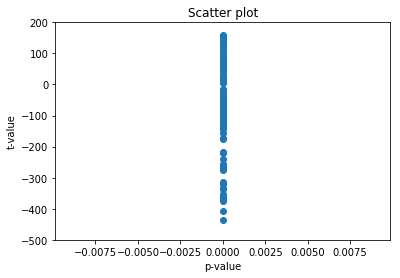

In [54]:
plt.ylim(-500,200)
# tvalue_list.sort()
# print(sorted(t_p_value_dict))

pvalue_list = []
for key in sorted(t_p_value_dict):
    pvalue_list.append(t_p_value_dict[key])
plt.scatter(x = pvalue_list, y = sorted(t_p_value_dict))

plt.xlabel('p-value')
plt.ylabel('t-value')
plt.title('Scatter plot')

t-valores negativos: 111
t-valores positivos:  70


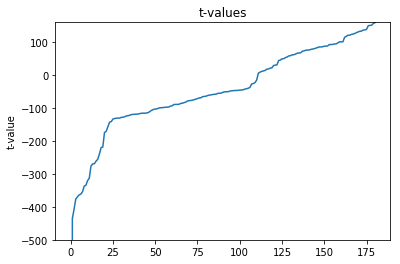

In [61]:
plt.ylim(-500,160)

plt.plot(sorted(t_p_value_dict))

# plt.xlabel('p-value')
plt.ylabel('t-value')
plt.title('t-values')

count = 0
for i in sorted(t_p_value_dict):
    if i < 0:
        count += 1

print('t-valores negativos:', count)
print('t-valores positivos: ', len(sorted(t_p_value_dict)) - count)

Analisando o primeiro gráfico, percebemos que os p-valores são extremamente baixos (na escala de e-100), significando que as nossas respostas são bastante confiáveis, ou seja, não ocorreram por acaso. E quais seriam estas respostas? Para isso usamos os t-valores obtidos nos testes t-student realizados. Os t-valores representam o quanto os dois grupos são diferentes ou parecidos, tendo valores altos se os grupos forem diferentes, e valores baixos caso sejam similares.
Analisando o segundo gráfico reparamos que há um número não tão diferente de valores negativos de valores positivos, o que é confirmado realizando-se a contagem (111 t-valores negativos e 70 positivos), isto indica que das nossas amostras, uma boa parte das famílias que possuíam altas medidas de centralidade, se mantiveram com altos valores ao mudarmos o tipo de trajetória e difusão. Porém, uma grande parte das famílias que possuíam altos valores, não se mantiveram no topo, uma vez que mudamos o tipo de trajetória e difusão.

https://www.statisticshowto.datasciencecentral.com/probability-and-statistics/t-test/